# Michał Stawikowski Lab 4

In [461]:
import numpy as np
import pandas as pd
import matplotlib as plt
import itertools
import sys
np.set_printoptions(threshold=sys.maxsize)
import timeit
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib
from scipy import special
%matplotlib inline

plt.rcParams["figure.figsize"] = (12, 8)
plt.style.use("bmh")
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# Implementation

In [482]:
#Market instance
class CRR_Market(object):
    
    def __init__(self,T,S,r,u,d):
        self.T = T #Number of periods
        self.S = S #S_0 = const
        self.r = r #Interest rate
        self.u = u #Upper rate
        self.d = d #Lower rate
        self.p = (1 + r - d) / (u-d) #Risk neutral probability
        self.is_calculated = 0
    
    #pseudo-recursive
    def pricePayout(self, payout, verbose = False): #Method for pricing generic payouts
        paths = np.array(list(itertools.product([self.u, self.d], repeat = self.T))) #U and d
        #paths of T length
        n = paths.shape[0]
        all_paths = [0]*n 
        for i in range(0,n):
            all_paths[i] = np.insert(arr = paths[i], values = 1, obj = 0) #Adding 1 on first place
        
        cum_path = np.cumprod(all_paths, axis = 1)
        all_path_values = cum_path * self.S #All possible paths for stock values
        
        if(verbose): #Printing informations
                print("Stock values paths:")
                print(all_path_values)
        
        payout_values = np.zeros(len(all_path_values))
        
        for i,v in enumerate(all_path_values):
            payout_values[i] = payout.fun(v)   #Values of payout at T given by payout function, based 
            #on the whole trajectory of stock values
        
        if(verbose):
                print("Payout values at T:")
                print(payout_values)
        
        i = len(payout_values)
        l = self.T + 1
        a = 1
        while(i>1):  #Rest of layers of payout values (at T-1,...,0)
            i = int(i/2)
            l = l - 1
            a = a*2
            if(payout.eu_am == "American"):
                    payout_values_till_t = np.zeros(len(all_path_values))
                    for it,v in enumerate(all_path_values):
                        payout_values_till_t[it] = payout.fun(v[0:l]) # Value of payout at T-l
            for j in range(0, i):
                #Expected value calcutaion
                payout_values[j] = (1.0/(1+self.r))*(self.p*payout_values[2*j]+(1-self.p)*payout_values[2*j+1])
                if(payout.eu_am == "American"):
                    payout_values[j] = max(payout_values[j], payout_values_till_t[a*j])
                    #Max from expected value (payout_values) and current value ( payout_values_till_t)
        
        return payout_values[0] #Payout price at 0
    #pseudo-recursive
    def priceOption(self, option, verbose = False): #Method for pricing options, 
#better optimized for options than pricePayout (especially for European options)
        option_values = np.zeros(self.T+1) 
        ST = [self.S * self.d ** (self.T-i) * self.u ** (i) for i in range(0,self.T + 1)]
        # stock values at T
        
        if (option.eu_am == "European"):
            
            for j in range(1, self.T+1): #Option values at T, simplified version without
                #identical payouts
                if option.put_call == 'Put':
                    option_values[j] = max(option.K-ST[j],0)
                elif option.put_call == 'Call':
                    option_values[j] = max(ST[j]-option.K,0)
            
            if(verbose): #Printing informations
                print("Option Values at T:")
                print(option_values)
            
            for i in range(self.T, 0, -1):  #Rest of layers of option values (at T-1,...,0)
                for j in range(0, i):
                    #Expected values calcucation
                    option_values[j] = (1.0/(1+self.r))*(self.p*option_values[j+1]+(1-self.p)*option_values[j])
            
            return option_values[0] #Option value at 0
        
        if (option.eu_am == "American"):
            if (not self.is_calculated):
                St = np.zeros((self.T+1,self.T+1)) #Stock values tree calcucation
                St[0,0] = self.S
                for i in range(1,self.T+1):
                    St[i,0] = St[i-1,0]*self.u
                    for j in range(1,i+1):
                        St[i,j] = St[i-1,j-1]*self.d
                self.St = St #Values of recombination tree
                self.is_calculated = 1
            
            option_values = np.zeros((self.T+1,self.T+1))
            
            for i in range(0,self.T+1): #Option values at T
                if option.put_call == 'Call':
                    option_values[self.T,i] = max(0, self.St[self.T,i]-option.K)
                elif option.put_call == 'Put':
                    option_values[self.T,i] = max(0, option.K-self.St[self.T,i])
            
            if(verbose):
                print("Option Values at T:")
                print(option_values[self.T,:])
            
            for i in range(self.T, 0, -1): #Rest of layers of option values (at T-1,...,0)
                for j in range(0, i):
                    expected_value = (1.0/(1+self.r))*(self.p*option_values[i,j]+(1-self.p)*option_values[i, j+1])
                    if option.put_call == 'Call':
                        call_value = max(0, self.St[i-1,j] - option.K)
                        option_values[i-1,j] = max(call_value, expected_value)
                    elif option.put_call == 'Put':
                        put_value = max(0, option.K - self.St[i-1,j])
                        option_values[i-1,j] = max(put_value, expected_value)
            return option_values[0,0] #Option value at 0

    def non_recursive_priceOption(self, option):
        full_sum = 0
        if option.put_call == 'Call':
            for i in range(0, self.T+1):
                full_sum = full_sum + special.binom(self.T, i)*self.p**i*(1-self.p)** \
                (self.T-i)*max(self.S*self.u**i*self.d**(self.T-i)-option.K,0)
            
        elif option.put_call == 'Put':
            for i in range(0, self.T+1):
                full_sum = full_sum + special.binom(self.T, i)*self.p**i*(1-self.p)** \
                (self.T-i)*max(option.K - self.S*self.u**i*self.d**(self.T-i),0)
        
        price = (1/(1+self.r)**self.T)*full_sum
        return price
    
                        
    def printTree(self): #Simple visualization of tree (rounded values for better display)
        if (not self.is_calculated):
            St = np.zeros((self.T+1,self.T+1))
            St[0,0] = self.S
            for i in range(1,self.T+1):
                St[i,0] = St[i-1,0]*self.u
                for j in range(1,i+1):
                    St[i,j] = St[i-1,j-1]*self.d
            self.St = St #Values of recombination tree
            self.is_calculated = 1
        print(np.matrix(self.St.T.astype(int)))
        

In [221]:
#Option instance
class Option(object):
    
    def __init__(self, put_call, eu_am, K):
        self.put_call = put_call #"Put" or "Call"
        self.eu_am = eu_am  #"European" or "American"
        self.K = K #Strike price of the option
       

In [476]:
#Generic Payout instance
class Payout(object):
    
    def __init__(self, fun, eu_am = "European"):
        self.fun = fun
        self.eu_am = eu_am
     

# Market initialization

In [477]:
market = CRR_Market(T=10,S=100,r=0.1,u=1.3,d=0.8)
market.printTree()

[[ 100  130  169  219  285  371  482  627  815 1060 1378]
 [   0   80  104  135  175  228  297  386  501  652  848]
 [   0    0   64   83  108  140  182  237  308  401  522]
 [   0    0    0   51   66   86  112  146  190  247  321]
 [   0    0    0    0   40   53   69   89  116  152  197]
 [   0    0    0    0    0   32   42   55   71   93  121]
 [   0    0    0    0    0    0   26   34   44   57   74]
 [   0    0    0    0    0    0    0   20   27   35   46]
 [   0    0    0    0    0    0    0    0   16   21   28]
 [   0    0    0    0    0    0    0    0    0   13   17]
 [   0    0    0    0    0    0    0    0    0    0   10]]


# Pricing options

## Two ways to initialize an option

In [381]:
x = lambda a : max(a[-1]-90,0) # Call option function
generic_payout_option = Payout(fun = x, eu_am = "European") #Generic payout initialization -
#function of call option

dedicated_option = Option("Call", "European", 90) #Dedicated option initialization

## Not optimiazed method

In [382]:
%%timeit
market.pricePayout(generic_payout_option)

19.4 ms ± 855 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [386]:
print("Price:")
market.pricePayout(generic_payout_option)

Price:


66.97006486520783

## Optimiazed method

In [383]:
%%timeit
market.priceOption(dedicated_option)

63.1 µs ± 1.21 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [387]:
print("Price:")
market.priceOption(dedicated_option)

Price:


66.97006486520782

## Non-recursive method

In [479]:
%%timeit
market.non_recursive_priceOption(dedicated_option)

48.4 µs ± 1.56 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [480]:
market.non_recursive_priceOption(dedicated_option)

66.97006486520779

As we can see the difference between first two is huge, another order of magnitude. Because the second method is not fully recursive, it obtained a similar result to the non-recursive method.

# American and European option pricing

In [399]:
#T=10, S=100, r=0.1, u=1.3, d=0.8, K=90
ce_option = Option("Call", "European", 90)
pe_option = Option("Put", "European", 90)
ca_option = Option("Call", "American", 90)
pa_option = Option("Put", "American", 90)
pricing = {'Type' : ['European','European', 'American', 'American'],
    'Option' : ['Call', 'Put', 'Call', 'Put'],
                          'Price': [market.priceOption(ce_option), market.priceOption(pe_option),
                                     market.priceOption(ca_option), market.priceOption(pa_option)]}
pricing = DataFrame(pricing, columns=['Type', 'Option', 'Price'])                                        
print(pricing.to_string(index=False))

     Type Option      Price
 European   Call  66.970065
 European    Put   1.665757
 American   Call  66.970065
 American    Put   5.598213


Surprisingly, European and American Call price are the same. In the case of Put, as it could been predicted, the American option is more expensive.

# Pricing of generic payouts

## Maximum of all values from the trajectory

In [405]:
market = CRR_Market(T=3,S=100,r=0.1,u=1.3,d=0.8)
payout_e = Payout(fun = max, eu_am = "European")
payout_a = Payout(fun = max, eu_am = "American")
pricing = {'Type' : ['European', 'American'],
    'Function' : ["Max", "Max"],
                          'Price': [market.pricePayout(payout_e), market.pricePayout(payout_a)]}
pricing = DataFrame(pricing, columns=['Type', 'Function', 'Price'])                                        
print(pricing.to_string(index=False))

     Type Function       Price
 European      Max  112.090759
 American      Max  116.086551


### With verbose = True

In [406]:
#European
market.pricePayout(payout_e, verbose = True)

Stock values paths:
[[100.  130.  169.  219.7]
 [100.  130.  169.  135.2]
 [100.  130.  104.  135.2]
 [100.  130.  104.   83.2]
 [100.   80.  104.  135.2]
 [100.   80.  104.   83.2]
 [100.   80.   64.   83.2]
 [100.   80.   64.   51.2]]
Payout values at T:
[219.7 169.  135.2 130.  135.2 104.  100.  100. ]


112.09075882794893

## Sum of all values from the trajectory

In [408]:
market = CRR_Market(T=3,S=100,r=0.1,u=1.3,d=0.8)
payout_e = Payout(fun = sum, eu_am = "European")
payout_a = Payout(fun = sum, eu_am = "American")
pricing = {'Type' : ['European', 'American'],
    'Function' : ["Sum", "Sum"],
                          'Price': [market.pricePayout(payout_e), market.pricePayout(payout_a)]}
pricing = DataFrame(pricing, columns=['Type', 'Function', 'Price'])                                        
print(pricing.to_string(index=False))

     Type Function       Price
 European      Sum  348.685199
 American      Sum  348.685199


## Mean of all values from the trajectory

In [410]:
market = CRR_Market(T=3,S=100,r=0.1,u=1.3,d=0.8)
payout_e = Payout(fun = np.mean, eu_am = "European")
payout_a = Payout(fun = np.mean, eu_am = "American")
pricing = {'Type' : ['European', 'American'],
    'Function' : ["Mean", "Mean"],
                          'Price': [market.pricePayout(payout_e), market.pricePayout(payout_a)]}
pricing = DataFrame(pricing, columns=['Type', 'Function', 'Price'])                                        
print(pricing.to_string(index=False))

     Type Function     Price
 European     Mean   87.1713
 American     Mean  100.0000


## Variance of all values from the trajectory

In [444]:
market = CRR_Market(T=10,S=100,r=0.1,u=1.3,d=0.8)
payout_e = Payout(fun = np.var, eu_am = "European")
payout_a = Payout(fun = np.var, eu_am = "American")
pricing = {'Type' : ['European', 'American'],
    'Function' : ["Variance", "Variance"],
                          'Price': [market.pricePayout(payout_e), market.pricePayout(payout_a)]}
pricing = DataFrame(pricing, columns=['Type', 'Function', 'Price'])                                        
print(pricing.to_string(index=False))

     Type  Function        Price
 European  Variance  3176.779288
 American  Variance  3238.114067


# Dependence of the option price on the number of periods

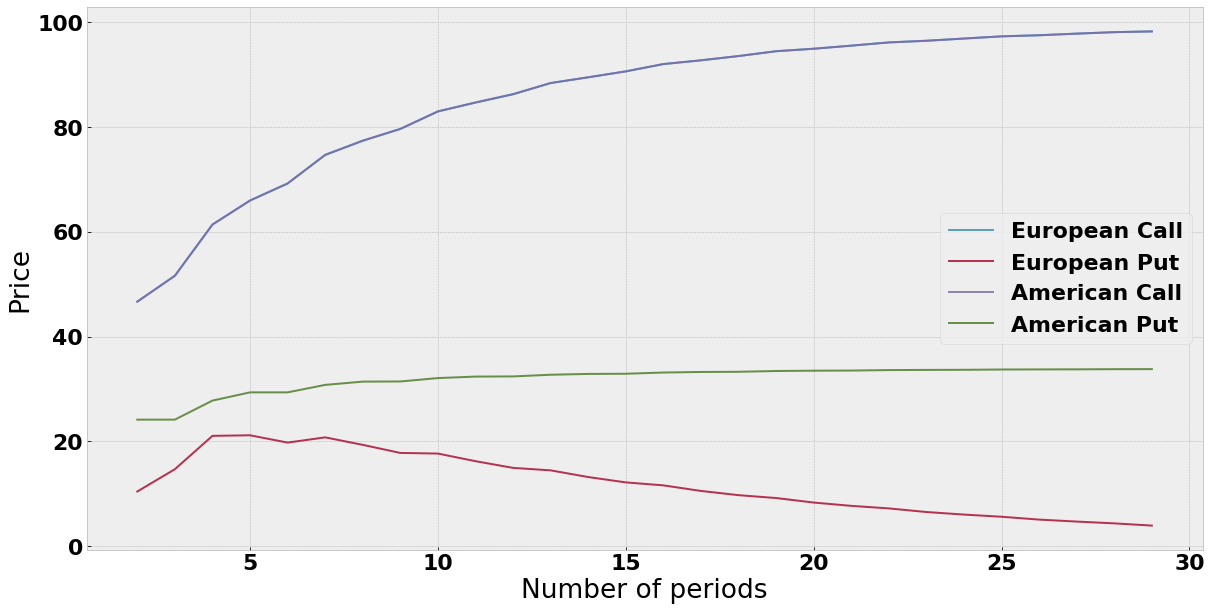

In [449]:
Ts = np.arange(2, 30, 1)

ce_option = Option("Call", "European", 90)
pe_option = Option("Put", "European", 90)
ca_option = Option("Call", "American", 90)
pa_option = Option("Put", "American", 90)

ce = []
pe = []
ca = []
pa = []
for t in Ts:
    market = CRR_Market(T=t,S=100,r=0.1,u=1.6,d=0.4)
    ce.append(market.priceOption(ce_option))
    pe.append(market.priceOption(pe_option))
    ca.append(market.priceOption(ca_option))
    pa.append(market.priceOption(pa_option))
    
fig = plt.figure(figsize = [20,10])
ax = plt.subplot(111)
plt.plot(Ts, ce, alpha = 0.8, markersize = 4, label = "European Call")
plt.plot(Ts, pe, alpha = 0.8, markersize = 4, label = "European Put")
plt.plot(Ts, ca, alpha = 0.8, markersize = 4, label = "American Call")
plt.plot(Ts, pa, alpha = 0.8, markersize = 4, label = "American Put")
plt.xlabel("Number of periods")
plt.ylabel("Price")
ax.legend()
plt.show()
    

American and European Call are the same.

# Dependence of the option price on the strike

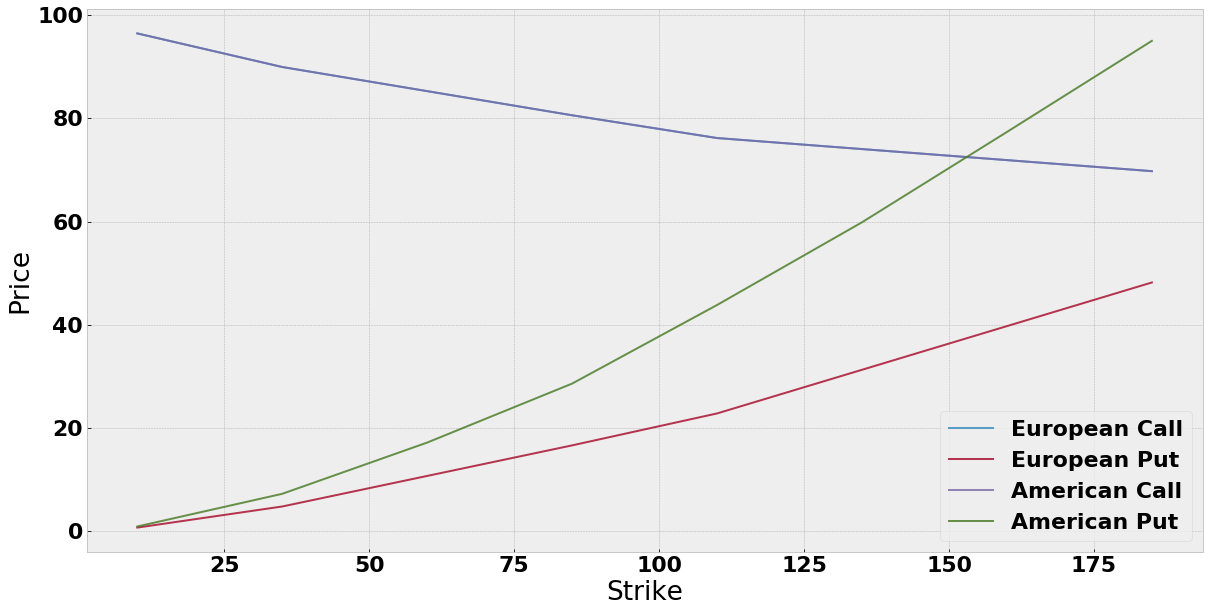

In [452]:
Ks = np.arange(10, 200, 25)


market = CRR_Market(T=t,S=100,r=0.1,u=1.6,d=0.4)

ce = []
pe = []
ca = []
pa = []
for k in Ks:
    ce_option = Option("Call", "European", k)
    pe_option = Option("Put", "European", k)
    ca_option = Option("Call", "American", k)
    pa_option = Option("Put", "American", k)
    ce.append(market.priceOption(ce_option))
    pe.append(market.priceOption(pe_option))
    ca.append(market.priceOption(ca_option))
    pa.append(market.priceOption(pa_option))
    
fig = plt.figure(figsize = [20,10])
ax = plt.subplot(111)
plt.plot(Ks, ce, alpha = 0.8, markersize = 4, label = "European Call")
plt.plot(Ks, pe, alpha = 0.8, markersize = 4, label = "European Put")
plt.plot(Ks, ca, alpha = 0.8, markersize = 4, label = "American Call")
plt.plot(Ks, pa, alpha = 0.8, markersize = 4, label = "American Put")
plt.xlabel("Strike")
plt.ylabel("Price")
ax.legend()
plt.show()

# Different payouts by number of periods

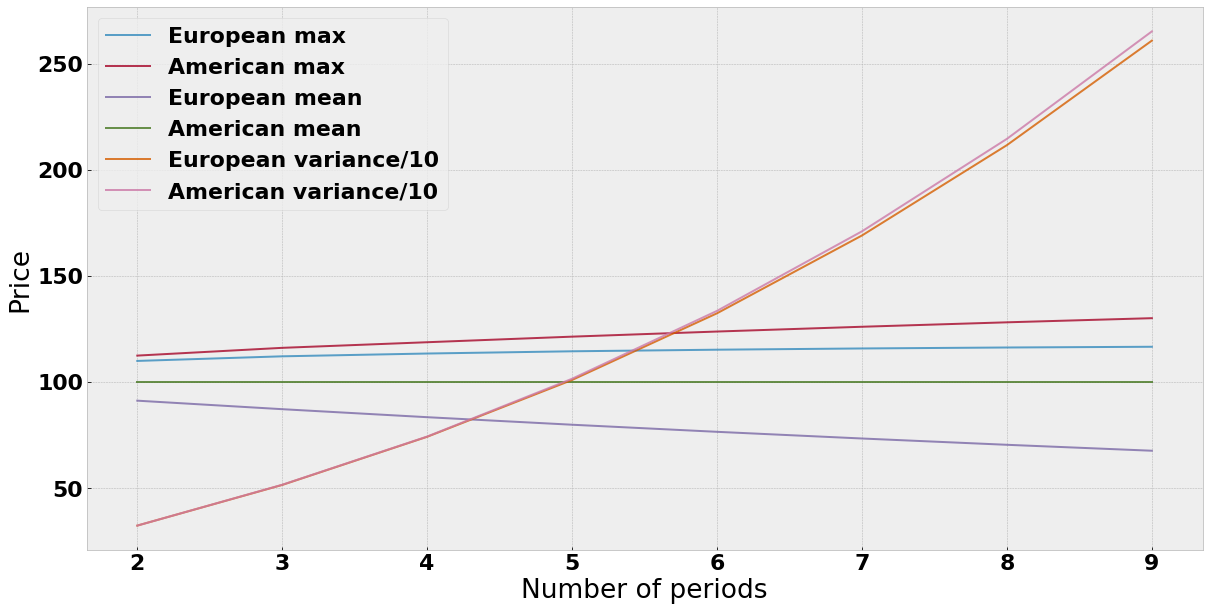

In [451]:
Ts = np.arange(2, 10, 1)

ce_payout = Payout(fun = max, eu_am = "European")
pe_payout = Payout(fun = max, eu_am = "American")

ca_payout = Payout(fun = np.mean, eu_am = "European")
pa_payout = Payout(fun = np.mean, eu_am = "American")

cc_payout = Payout(fun = np.var, eu_am = "European")
pp_payout = Payout(fun = np.var, eu_am = "American")

ce = []
pe = []
ca = []
pa = []
cc = []
pp = []
for t in Ts:
    market = CRR_Market(T=t,S=100,r=0.1,u=1.3,d=0.8)
    ce.append(market.pricePayout(ce_payout))
    pe.append(market.pricePayout(pe_payout))
    ca.append(market.pricePayout(ca_payout))
    pa.append(market.pricePayout(pa_payout))
    cc.append(market.pricePayout(cc_payout)/10)
    pp.append(market.pricePayout(pp_payout)/10)
    
fig = plt.figure(figsize = [20,10])
ax = plt.subplot(111)
plt.plot(Ts, ce, alpha = 0.8, markersize = 4, label = "European max")
plt.plot(Ts, pe, alpha = 0.8, markersize = 4, label = "American max")
plt.plot(Ts, ca, alpha = 0.8, markersize = 4, label = "European mean")
plt.plot(Ts, pa, alpha = 0.8, markersize = 4, label = "American mean")
plt.plot(Ts, cc, alpha = 0.8, markersize = 4, label = "European variance/10")
plt.plot(Ts, pp, alpha = 0.8, markersize = 4, label = "American variance/10")
plt.xlabel("Number of periods")
plt.ylabel("Price")
ax.legend()
plt.show()

,,Potwierdzam samodzielność powyższej pracy oraz niekorzystanie przeze mnie z niedozwolonych źródeł"